<a href="https://colab.research.google.com/github/mostafaramadann/30Days-of-Remontada/blob/main/Day2/League_of_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configurations and Importing Libraries**

---



In [55]:
import numpy as np
import tensorflow as tf
import os 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tqdm.notebook import trange, tqdm
import cv2
import gc
import random

In [56]:
GRID_SIZE = 14
IMAGE_SIZE = 256
EPOHCS = 40
TRAIN_SIZE = 600

In [3]:
if not os.path.isfile('mid.names'):
  !wget -O data.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/EXtR0nvmucdAsudR0Vr3dxgBvWq_98sW6JqdTnjVwR5XEw?e=QRAMYm&download=1"
  !unzip -q data.zip
  !rm -f data.zip
  !rm -f yolov3_LoL_champions.weights
  !rm -rf sample_data

# **Data Exploration** 

---

In [4]:
!cat mid.names && echo -e "\nnumber of classes is" && grep -c $ mid.names

veigar
diana
vladimir
ryze
ekko
irelia
master_yi
nocturne
pantheon
yorick
number of classes is
10


*mid_dataset* 
has two folders:<br>
1- images<br>
2- labels<br>
The images folders contains some noisy image and each image has only one champion <br>
The labels folder contain txt file that corresponds to image in the images folder<br>
The txt file has x,y,w,h normalized with respect to image size (x,y) is the center of the champion's icon


1 0.082270 0.917092 0.075255 0.079082
(360, 360, 3)


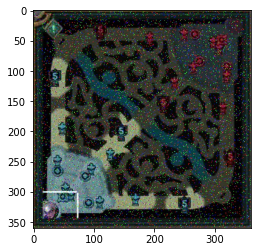

In [24]:
image = plt.imread("/content/mid_dataset/images/coloured_noised_diana_1_00000.jpg")
plt.imshow(image)
!cat /content/mid_dataset/labels/coloured_noised_diana_1_00000.txt
print("\n"+str(image.shape))

In [57]:
ROOT_IMAGES_PATH = "/content/mid_dataset/images"
ROOT_LABELS_PATH = "/content/mid_dataset/labels"
IMAGES_PATHS = os.listdir(ROOT_IMAGES_PATH)
LABELS_PATHS = os.listdir(ROOT_LABELS_PATH)
IMAGES_PATHS = sorted(IMAGES_PATHS)
LABELS_PATHS = sorted(LABELS_PATHS) 
print(len(IMAGES_PATHS))
print(len(LABELS_PATHS))
print(IMAGES_PATHS)
print(LABELS_PATHS)

7200
7200
['coloured_noised_diana_1_00000.jpg', 'coloured_noised_diana_1_00001.jpg', 'coloured_noised_diana_1_00002.jpg', 'coloured_noised_diana_1_00003.jpg', 'coloured_noised_diana_1_00004.jpg', 'coloured_noised_diana_1_00005.jpg', 'coloured_noised_diana_1_00006.jpg', 'coloured_noised_diana_1_00007.jpg', 'coloured_noised_diana_1_00008.jpg', 'coloured_noised_diana_1_00009.jpg', 'coloured_noised_diana_1_00010.jpg', 'coloured_noised_diana_1_00011.jpg', 'coloured_noised_diana_1_00012.jpg', 'coloured_noised_diana_1_00013.jpg', 'coloured_noised_diana_1_00014.jpg', 'coloured_noised_diana_1_00015.jpg', 'coloured_noised_diana_1_00016.jpg', 'coloured_noised_diana_1_00017.jpg', 'coloured_noised_diana_1_00018.jpg', 'coloured_noised_diana_1_00019.jpg', 'coloured_noised_diana_1_00020.jpg', 'coloured_noised_diana_1_00021.jpg', 'coloured_noised_diana_1_00022.jpg', 'coloured_noised_diana_1_00023.jpg', 'coloured_noised_diana_1_00024.jpg', 'coloured_noised_diana_1_00025.jpg', 'coloured_noised_diana_1_00

# **Data Cleaning and preprocessing**

---



In [58]:
def read_txt(txt_file):
  with open(txt_file,'r') as f:
    line = f.readline()
    category,x,y,w,h = line.split(" ")
    category,x,y,w,h = int(category),float(x),float(y),float(w),float(h)
    return category,x,y,w,h

In [59]:
def number_to_champion()->dict:
  with open("mid.names","r") as f:
    lines = f.readlines()
  champs = {i:champ.strip() for i,champ in enumerate(lines)}
  return champs

In [60]:
def normalize(image):
  image = image.copy()
  if image.max()-image.min() == 0:
    return image/image.max()
  return image-image.min()/(image.max()-image.min())

def denormalize(bbox,image_shape):
  img_h,img_w,_ = image_shape
  x,y,w,h = bbox
  x,y,w,h = int(x*img_w), int(y*img_h), int(w*img_w) ,int(h*img_h)
  return x,y,w,h

def denoise(image):
  image = image.copy()
  blurred = cv2.GaussianBlur(image,(3,3), 1);
  image = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
  image = cv2.medianBlur(image,3)
  return image

In [61]:
def visualize(image,bbox=None):
  image = image.copy()
  plt.figure(figsize=(10,10))
  if bbox is not None:
    bbox = denormalize(bbox,image.shape)
    x,y,w,h = bbox
    image = cv2.rectangle(image,(x,y),(x+w,y+h),(255,255,0),2)
  plt.imshow(image)

In [62]:
champions = number_to_champion()

In [63]:
read_txt("/content/mid_dataset/labels/coloured_noised_diana_1_00001.txt")

(1, 0.08227, 0.921556, 0.072704, 0.072704)

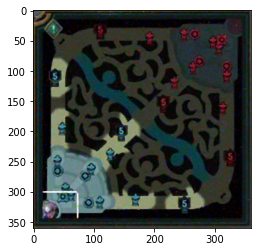

In [64]:
image = plt.imread("/content/mid_dataset/images/coloured_noised_diana_1_00000.jpg")
image = denoise(image)
plt.imshow(image,cmap="gray")

In [65]:
def get_champs_images():
  global champions
  champs_imgs = dict()
  champs_dims = []
  for champion_index in champions:
    champion = champions[champion_index]
    image = plt.imread(f"/content/mid_dataset/images/{champion}_1_00000.jpg")
    _,x,y,w,h = read_txt(f"/content/mid_dataset/labels/{champion}_1_00000.txt")
    bbox = denormalize((x,y,w,h),image.shape)
    x,y,w,h = bbox
    champ_icon = image[y-h//2:y+h//2,x-h//2:x+h//2,:]
    champ_icon = cv2.resize(champ_icon,(30,30))
    champs_imgs[champion_index] = champ_icon
    champs_dims.append([w,h])

  return champs_dims,champs_imgs

In [66]:
champs_dims,champs_imgs = get_champs_images()

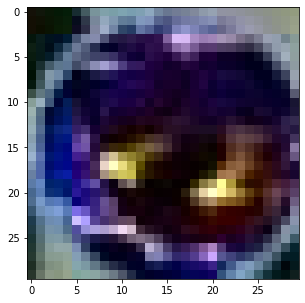

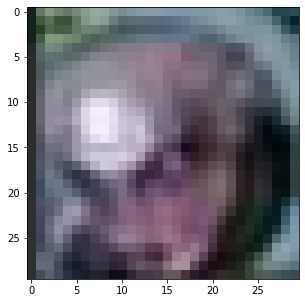

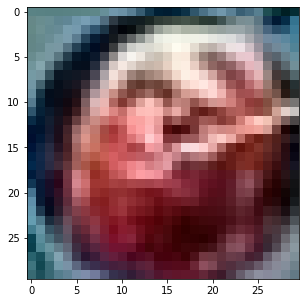

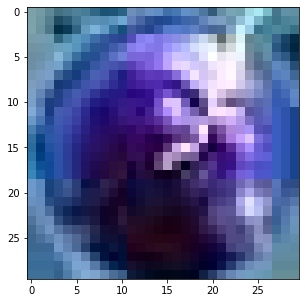

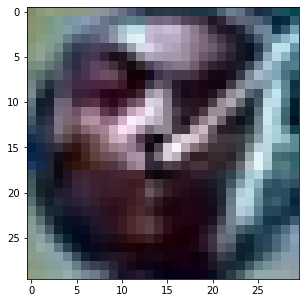

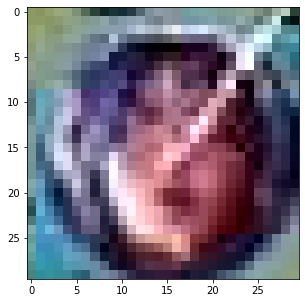

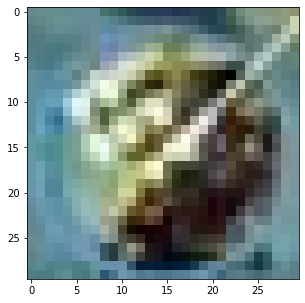

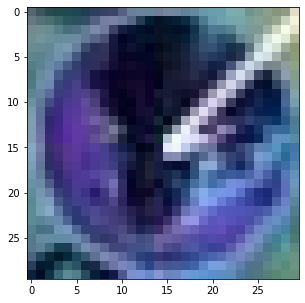

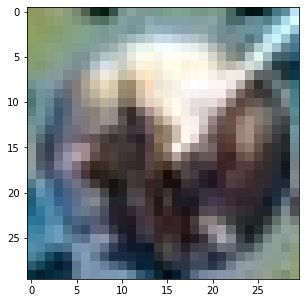

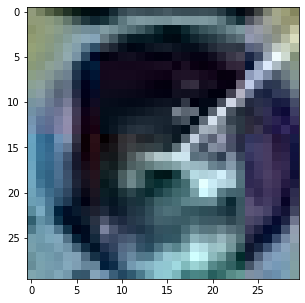

In [67]:
for champ in champs_imgs.values():
  plt.figure(figsize=(5,5))
  plt.imshow(champ)

In [78]:
def augment_image(minimap_img,champs_imgs:dict,champ_in_image:int):
  global champions

  n_of_champions = Random().randint(0,9) ## number of champions to be added to the image

  if n_of_champions == 0:
    return minimap_img

  minimap_img = minimap_img.copy()
  h,w,_ = minimap_img.shape


  all_champs = set(champions.keys())
  champ_in_image = {champ_in_image}
  champs_not_in_image = all_champs.difference(champ_in_image)
  for i,champ in enumerate(champs_not_in_image):
      x,y = Random().randint(50,w-50),Random().randint(50,h-50)
      ### save bbox of each champion and check for overlap
      minimap_img[y:y+30,x:x+30] = champs_imgs[champ]
      if (i+1) == n_of_champions:
        break

  return minimap_img

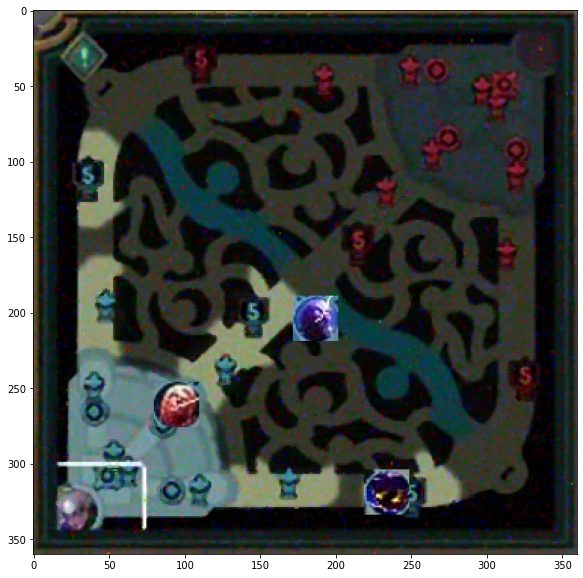

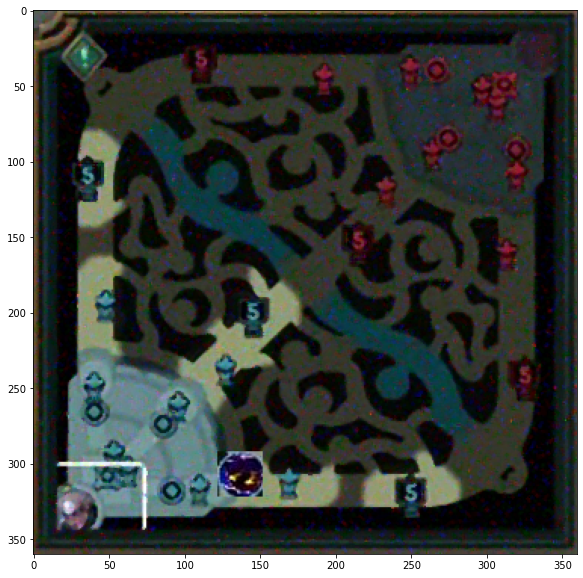

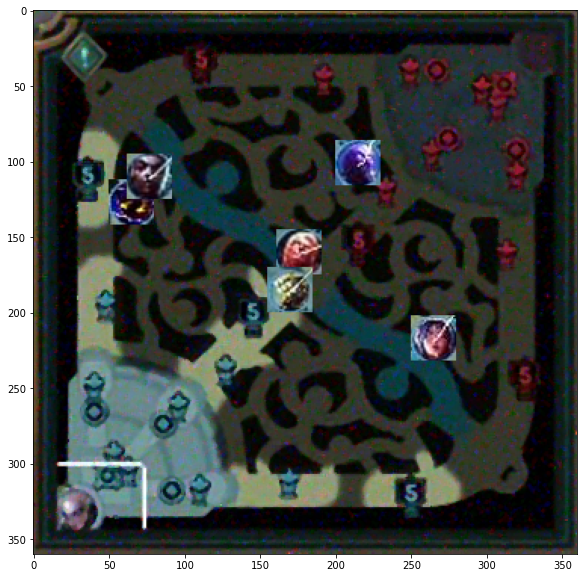

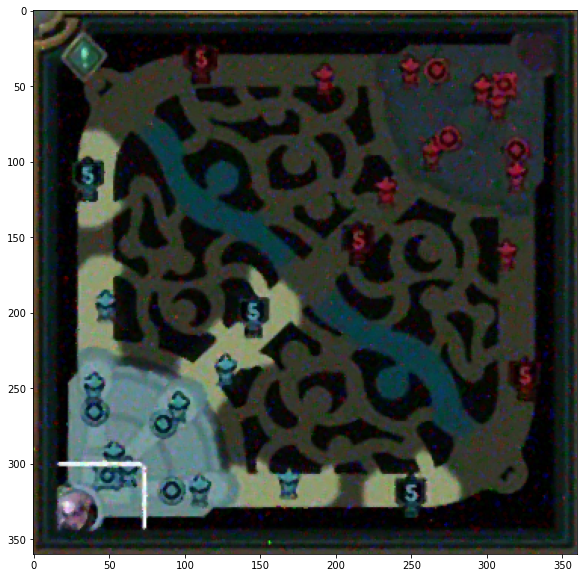

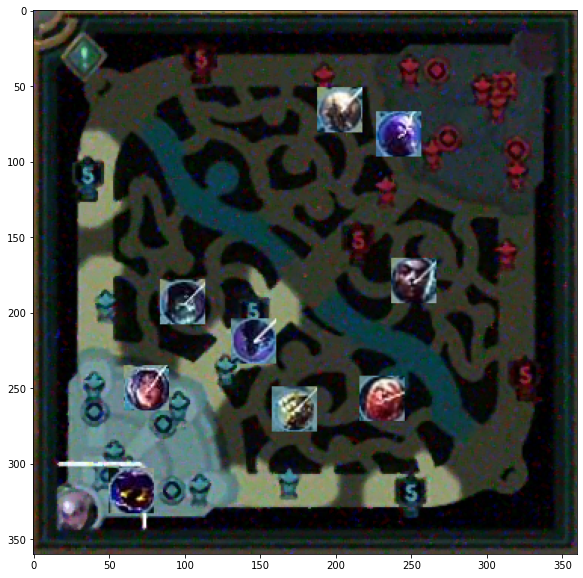

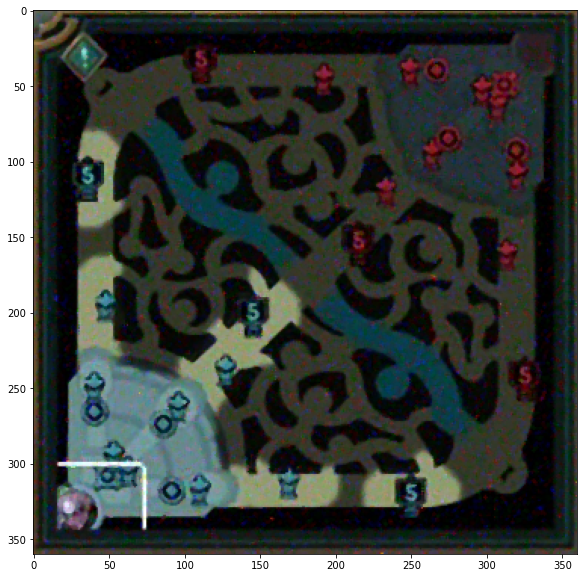

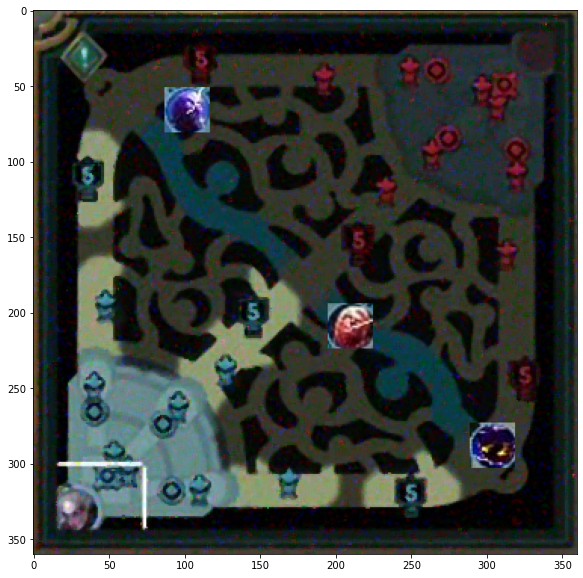

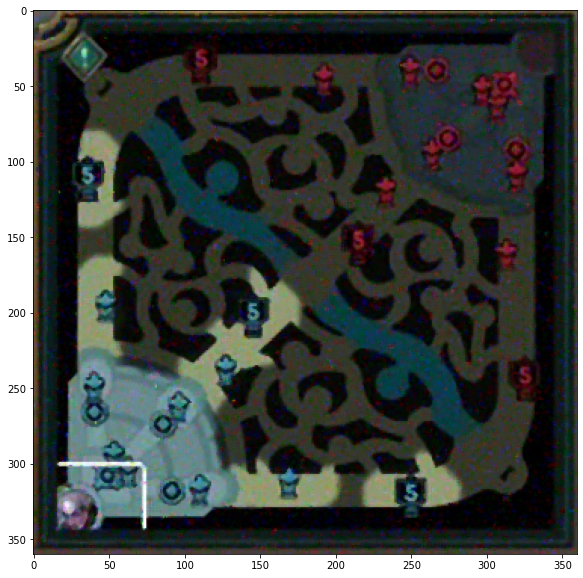

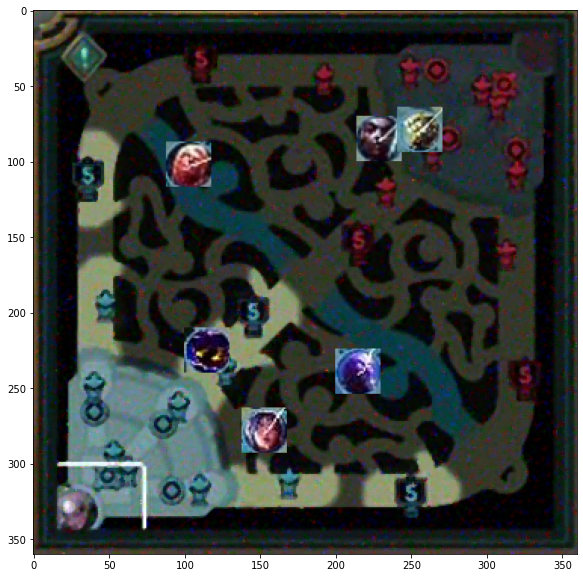

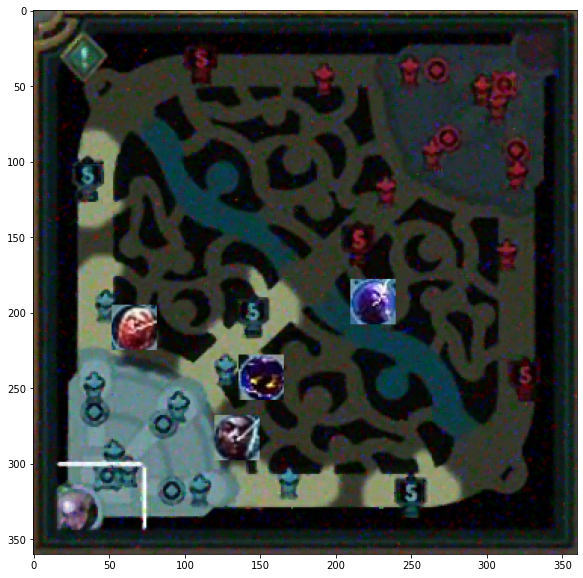

In [80]:
for i in range(10):
  minimap = plt.imread(os.path.join(ROOT_IMAGES_PATH,IMAGES_PATHS[i]))
  if "noised" in IMAGES_PATHS[i]:
    minimap = denoise(minimap)
  category,x,y,w,h = read_txt(os.path.join(ROOT_LABELS_PATH,LABELS_PATHS[i]))
  newminimap = augment_image(minimap,champs_imgs,category)
  plt.figure(figsize=(10,10))
  plt.imshow(newminimap)